# Stock price Analysis using NLP

In [ ]:
!pip install snscrape

!pip3 install ktrain

!python -m pip install tensorflow_text

!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importing Libraries
#
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import ktrain
from ktrain import text
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sn
import os
import snscrape.modules.twitter as sntwitter
import re, string
import nltk
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer
from time import time
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
from textblob import TextBlob

from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam,SGD,RMSprop

from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
nltk.download('wordnet')
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB  
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime as dtime
import collections

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def find_the (text):
    while len(re.findall('##' , text)) != 0:
        text = re.sub('##' , '#' ,text)
    while len(re.findall('@@' , text)) != 0:
        text = re.sub('@@' , '@' ,text)

    no_h = len(re.findall('#',text))
    #make sure the @ is changed for at
    no_a = len(re.findall('@',text))
    
    text = re.sub('@(\s|\.|\?|,|;|:|!|\(|\))', 'at' , text)
    text = re.sub('\s' , ' ' , text)
    text = re.sub('\S@' , ' @' , text)
    text = re.sub('\S#' , ' #' , text)

    #while len(re.findall('\s\s' , text)) != 0:
    #    text = re.sub('\s\s' , '\s' ,text)

    #none_repeat = text
    text_a = text.split()

            
    return text

In [ ]:
# Applying Lemmmatizer to remove tenses from texts.
lemmatizer = WordNetLemmatizer()
#stemmer = SnowballStemmer("english")
STOPWORDS.update(['mkr', 'didn', 'bc', 'n', 'm', 
                  'im', 'll', 'y', 've', 'u', 'ur', 'don', 
                  'p', 't', 's', 'aren', 'kp', 'o', 'kat', 
                  'de', 're', 'amp', 'will'])# 'rt'
corpus = []
def preprocess_tweet(tweet):
    tweet = re.sub(r"won\'t", "will not", tweet)
    tweet = re.sub(r"can\'t", "can not", tweet)
    tweet = re.sub(r"n\'t", " not", tweet)
    tweet = re.sub(r"\'re", " are", tweet)
    tweet = re.sub(r"\'s", " is", tweet)
    tweet = re.sub(r"\'d", " would",tweet)
    tweet = re.sub(r"\'ll", " will", tweet)
    tweet = re.sub(r"\'t", " not", tweet)
    tweet = re.sub(r"\'ve", " have", tweet)
    tweet = re.sub(r"\'m", " am", tweet)
    #tweet = re.sub('[^a-zA-Z]',' ',tweet)
    #tweet = re.sub(r'[^\x00-\x7f]','',tweet)
    #tweet = " ".join([stemmer.stem(word) for word in tweet.split()])
    tweet = [lemmatizer.lemmatize(word) for word in tweet.split() if not word in set(STOPWORDS)]
    tweet = ' '.join(tweet)
    return tweet

In [ ]:
# Creating a tag maker function to extract @'s and #'s as the data is cleaned by the lemmatizer so as not to alter the tags
def tag_maker (text):
  text_a = text.split()
  tag_a = []
  for r in range(0, len(text_a)):
    if text_a[r].startswith('#') or text_a[r].startswith('@'):
      tag_name = '<<yellowstone<<' + str(len(tag_a)) + '>>yellowstone>>'
      tag_a.append(text_a[r])
      text_a[r] = tag_name

  r_text = ' '.join(text_a)

  return [r_text , tag_a]

In [ ]:
# Creating a tag replacer function replaces tags from text that has been lematized to the original @'s and #'s


def tag_replacer (text , tag_a):
  text_a = text.split()

  for r in range(0, len(text_a)):
    if ('<<yellowstone<<' in text_a[r]) and ('>>yellowstone>>' in text_a[r]):
      num = text_a[r]
      num = num[15:][:-15]
      num = int(num)
      text_a[r] = tag_a[num]

  r_text = ' '.join(text_a)

  return r_text

In [ ]:
# Creating a lema and stem function to call the tag maker the lematizer and the tag replacer

def tags_lema_stem(text):
  for_lem = tag_maker(text)
  for_tag_removal = preprocess_tweet(for_lem[0])
  r_text = tag_replacer(for_tag_removal, for_lem[1])

  return r_text

In [ ]:
# fuction to get the ats and hashes out 

def hash_and_ats (text):
    text_a = text.split()
    hash_list = []
    at_list = []
    
    for a in text_a:
        
        if a.startswith('#'):
            a = a.lower()
            hash_list.append(a)
        elif a.startswith('@'):
            at_list.append(a)

    return [hash_list , at_list]

In [ ]:
# removes words that start with at predefined set of characters in a list
def header_remover(text, hr):
    to_drop = hr
    text_a = text.split()
    for g in range(len(text_a)-1, -1 , -1):
        for a in to_drop:
            if text_a[g].startswith(a):
                text_a.pop(g)
                break

    text = ' '.join(text_a)
    return text

In [ ]:
# Polarity
# Function to get polarity(sentiments) of text using the module textblob
#
def get_polarity(text):
    try:
        textblob = TextBlob(text)
        pol = textblob.sentiment.polarity
    except:
        pol = 0.0
    return pol

In [ ]:
# Subjectivity
# Function to get polatiy of text using the module textblob
def get_subjectivity(text):
    try:
        textblob = TextBlob(text)
        subj = textblob.sentiment.subjectivity
    except:
        subj = 0.0
    return subj

In [ ]:
# Labelling sentiments to either Positive or Negative
#
def positive_negative(f):
	if f == 0:
		return 'Neutral'
	elif f < 0:
		return 'Negative'
	elif f > 0:
		return 'Positive'

In [ ]:
# Labelling sentiments to either Positive or Negative
#
def positive_negative_b(f):
	if f < 0:
		return 'Negative'
	elif f >= 0:
		return 'Positive'

In [ ]:
ENTRIES = 15
F_SIZE = (15,15)
THRESHOLD = 1.5
ORDER = 0
GRAPHING_COUNT = 7

In [ ]:
file_list = os.listdir()
file_lname = 'tweets'
for a in file_list:
  if 'tweet' in a:
    file_lname = a

In [ ]:
print(file_lname)

Appletweets.csv


In [ ]:
try :
  pd.read_csv(file_lname)
except:
  start_scrape = True
  print('Scrapping')
else:
  print ('Loading from file')
  tweets_df2 = pd.read_csv(file_lname)

Loading from file


In [ ]:
if start_scrape == True:
  # Creating list to append tweet data to
  tweets_list2 = []

  # Using TwitterSearchScraper to scrape data and append tweets to list
  for i,tweet in enumerate(sntwitter.TwitterSearchScraper('Apple company').get_items()):
      if i>5000:
          break
      tweets_list2.append([tweet.date, tweet.id, tweet.content, tweet.username])
      
  # Creating a dataframe from the tweets list above
  tweets_df2 = pd.DataFrame(tweets_list2, columns=['Datetime', 'Tweet Id', 'Tweet', 'Username'])
  file_name = 'tweets '+ str(dtime.now())
  tweets_df2.to_csv(file_name, index = False)

In [ ]:
#Not load the Appletweets.csv file
tweets_df2 = pd.read_csv('Appletweets.csv')

In [ ]:
# Previewing the top 5 of data
#
tweets_df2.head(5)

,Datetime,Tweet Id,Tweet,Username
0,2022-12-10 01:58:31+00:00,1601395908603936769,@AndToddsaid @pinkheretic Except the Apple com...,CubeSteve
1,2022-12-09 21:06:25+00:00,1601322397982134273,"@elonmusk apple company, I still I have been ...",ankossi88
2,2022-12-09 21:04:10+00:00,1601321832120201216,"apple company, I still I have been going sinc...",ankossi88
3,2022-12-09 17:54:37+00:00,1601274131370356736,@OlaElectric Ola move 3.0 phir 4.0 phir 5.0 ly...,ANSHUGA67144275
4,2022-12-09 15:58:11+00:00,1601244830038134784,"@NaughtieHazel In this life, you cum and you g...",daniel_akhilome


## Data Cleaning

In [ ]:
# dropping irrelevant columns
df = tweets_df2.drop(['Tweet Id', 'Username'], axis = 1) 
#renaming the 'Tweet' columns
df.rename(columns = {'Tweet':'tweet'}, inplace = True)
# previewing datset
df.head()

,Datetime,tweet
0,2022-12-10 01:58:31+00:00,@AndToddsaid @pinkheretic Except the Apple com...
1,2022-12-09 21:06:25+00:00,"@elonmusk apple company, I still I have been ..."
2,2022-12-09 21:04:10+00:00,"apple company, I still I have been going sinc..."
3,2022-12-09 17:54:37+00:00,@OlaElectric Ola move 3.0 phir 4.0 phir 5.0 ly...
4,2022-12-09 15:58:11+00:00,"@NaughtieHazel In this life, you cum and you g..."


In [ ]:
# getting non repetitive column
# handling whitespaces
df['nr_tweet'] = df.tweet.apply(lambda d: find_the(d))
df.head()

,Datetime,tweet,nr_tweet
0,2022-12-10 01:58:31+00:00,@AndToddsaid @pinkheretic Except the Apple com...,@AndToddsaid @pinkheretic Except the Apple com...
1,2022-12-09 21:06:25+00:00,"@elonmusk apple company, I still I have been ...","@elonmusk apple company, I still I have been ..."
2,2022-12-09 21:04:10+00:00,"apple company, I still I have been going sinc...","apple company, I still I have been going sinc..."
3,2022-12-09 17:54:37+00:00,@OlaElectric Ola move 3.0 phir 4.0 phir 5.0 ly...,@OlaElectric Ola move 3.0 phir 4.0 phir 5.0 ly...
4,2022-12-09 15:58:11+00:00,"@NaughtieHazel In this life, you cum and you g...","@NaughtieHazel In this life, you cum and you g..."


In [ ]:
# We take the non repetitive tweets and change them to lower case, expose them to the tags_lema_stem 
# as well as, removing the (not so sure) while still maintaining the hashtags and ats


nltk.download('all')
df['c_tweet'] = df['nr_tweet'].str.lower()

df['c_tweet'] = df['c_tweet'].apply (lambda i : tags_lema_stem(i))

df['c_tweet'] = df['c_tweet'].apply(lambda i : re.sub('[^a-zA-Z0-9_#@ ]','',i)) #maintains the hashtags and the @'s
df.head()

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

,Datetime,tweet,nr_tweet,c_tweet
0,2022-12-10 01:58:31+00:00,@AndToddsaid @pinkheretic Except the Apple com...,@AndToddsaid @pinkheretic Except the Apple com...,@andtoddsaid @pinkheretic except apple company...
1,2022-12-09 21:06:25+00:00,"@elonmusk apple company, I still I have been ...","@elonmusk apple company, I still I have been ...",@elonmusk apple company still going tenth seri...
2,2022-12-09 21:04:10+00:00,"apple company, I still I have been going sinc...","apple company, I still I have been going sinc...",apple company still going tenth series waiting...
3,2022-12-09 17:54:37+00:00,@OlaElectric Ola move 3.0 phir 4.0 phir 5.0 ly...,@OlaElectric Ola move 3.0 phir 4.0 phir 5.0 ly...,@olaelectric ola move 30 phir 40 phir 50 lya 2...
4,2022-12-09 15:58:11+00:00,"@NaughtieHazel In this life, you cum and you g...","@NaughtieHazel In this life, you cum and you g...",@naughtiehazel life cum go iphone 14 apple com...


In [ ]:
# getting the hashtag and ats columns
#
df['hashtags'] = df['nr_tweet'].apply(lambda f : hash_and_ats(f)[0])
df['ats'] = df['nr_tweet'].apply(lambda f : hash_and_ats(f)[1])

# preview of random 20 
#
df.sample(2)

,Datetime,tweet,nr_tweet,c_tweet,hashtags,ats
1832,2022-07-30 22:18:33+00:00,BBC News &gt; Barco NV &gt; Apple (company) &g...,BBC News &gt; Barco NV &gt; Apple (company) &g...,bbc news gt barco nv gt apple company gt cd gl...,[],[]
2667,2022-04-08 06:48:02+00:00,Brilliant offer by Apple company \n10% off on ...,Brilliant offer by Apple company 10% off on e...,brilliant offer apple company 10 every product...,[#letsgoimagine],[]


In [ ]:
# Removing the hash and Ats

df['m_tweet'] = df['c_tweet'].apply(lambda i : header_remover(i , ['#' , '@']))
df['h_tweet'] = df['c_tweet'].apply(lambda i : header_remover(i , ['@']))
df['a_tweet'] = df['c_tweet'].apply(lambda i : header_remover(i , ['#']))

In [ ]:
# the rest of the stats
df['no_of_punctuations'] = df.tweet.apply(lambda x : len(re.findall('[^a-zA-Z0-9_ ]', x)))
df['no_of_at'] = df['ats'].apply ( lambda s : len(s))
df['no_of_hashes'] = df['ats'].apply ( lambda s : len(s))
df['no_of_words'] = df['nr_tweet'].apply ( lambda s : len(s.split()))

# no of words without @
df['no_of_words_no_at'] = df['no_of_words'] - df['no_of_at']

# no of words without #
df['no_of_words_no_hash'] = df['no_of_words'] - df['no_of_hashes']

# no of words without @ and #
df['no_of_words_no_at_hash'] = df['no_of_words'] - df['no_of_at'] - df['no_of_hashes']
df['length_of_tweet'] = df['nr_tweet'].apply (lambda y : len(y))


In [ ]:
# Viewing our current dataset

df.head(5)

,Datetime,tweet,nr_tweet,c_tweet,hashtags,ats,m_tweet,h_tweet,a_tweet,no_of_punctuations,no_of_at,no_of_hashes,no_of_words,no_of_words_no_at,no_of_words_no_hash,no_of_words_no_at_hash,length_of_tweet
0,2022-12-10 01:58:31+00:00,@AndToddsaid @pinkheretic Except the Apple com...,@AndToddsaid @pinkheretic Except the Apple com...,@andtoddsaid @pinkheretic except apple company...,[],"[@AndToddsaid, @pinkheretic]",except apple company part set fruit apples whe...,except apple company part set fruit apples whe...,@andtoddsaid @pinkheretic except apple company...,6,2,2,26,24,24,22,141
1,2022-12-09 21:06:25+00:00,"@elonmusk apple company, I still I have been ...","@elonmusk apple company, I still I have been ...",@elonmusk apple company still going tenth seri...,[],[@elonmusk],apple company still going tenth series waiting...,apple company still going tenth series waiting...,@elonmusk apple company still going tenth seri...,7,1,1,56,55,55,54,288
2,2022-12-09 21:04:10+00:00,"apple company, I still I have been going sinc...","apple company, I still I have been going sinc...",apple company still going tenth series waiting...,[],[],apple company still going tenth series waiting...,apple company still going tenth series waiting...,apple company still going tenth series waiting...,6,0,0,55,55,55,55,278
3,2022-12-09 17:54:37+00:00,@OlaElectric Ola move 3.0 phir 4.0 phir 5.0 ly...,@OlaElectric Ola move 3.0 phir 4.0 phir 5.0 ly...,@olaelectric ola move 30 phir 40 phir 50 lya 2...,[],[@OlaElectric],ola move 30 phir 40 phir 50 lya 2032 tak mil j...,ola move 30 phir 40 phir 50 lya 2032 tak mil j...,@olaelectric ola move 30 phir 40 phir 50 lya 2...,11,1,1,51,50,50,49,256
4,2022-12-09 15:58:11+00:00,"@NaughtieHazel In this life, you cum and you g...","@NaughtieHazel In this life, you cum and you g...",@naughtiehazel life cum go iphone 14 apple com...,[],[@NaughtieHazel],life cum go iphone 14 apple company release ip...,life cum go iphone 14 apple company release ip...,@naughtiehazel life cum go iphone 14 apple com...,5,1,1,27,26,26,25,144


In [ ]:
# contains a list of the beginning of the words that should be dropped
#
header_drop = ['http']

In [ ]:
# Finding the number of digits contained in the tweet
#
df['is_there_digit'] = df['m_tweet'].apply(lambda y : len(re.findall('[0-9]' , y)))

In [ ]:
# Getting the all the digits that are not 0

m = df[(df['is_there_digit'] != 0)]

In [ ]:
# removing the http from the m

m['m_tweet'] = m['m_tweet'].apply(lambda r : header_remover(r, ['http']))

In [ ]:
m['is_there_digit'] = m['m_tweet'].apply(lambda y : len(re.findall('[0-9]' , y)))

In [ ]:
m[(m['is_there_digit'] != 0)]

,Datetime,tweet,nr_tweet,c_tweet,hashtags,ats,m_tweet,h_tweet,a_tweet,no_of_punctuations,no_of_at,no_of_hashes,no_of_words,no_of_words_no_at,no_of_words_no_hash,no_of_words_no_at_hash,length_of_tweet,is_there_digit
3,2022-12-09 17:54:37+00:00,@OlaElectric Ola move 3.0 phir 4.0 phir 5.0 ly...,@OlaElectric Ola move 3.0 phir 4.0 phir 5.0 ly...,@olaelectric ola move 30 phir 40 phir 50 lya 2...,[],[@OlaElectric],ola move 30 phir 40 phir 50 lya 2032 tak mil j...,ola move 30 phir 40 phir 50 lya 2032 tak mil j...,@olaelectric ola move 30 phir 40 phir 50 lya 2...,11,1,1,51,50,50,49,256,10
4,2022-12-09 15:58:11+00:00,"@NaughtieHazel In this life, you cum and you g...","@NaughtieHazel In this life, you cum and you g...",@naughtiehazel life cum go iphone 14 apple com...,[],[@NaughtieHazel],life cum go iphone 14 apple company release ip...,life cum go iphone 14 apple company release ip...,@naughtiehazel life cum go iphone 14 apple com...,5,1,1,27,26,26,25,144,4
5,2022-12-09 13:31:28+00:00,@NBCNews apple company nor any of theme that w...,@NBCNews apple company nor any of theme that w...,@nbcnews apple company theme worked apple stve...,[],[@NBCNews],apple company theme worked apple stve job auth...,apple company theme worked apple stve job auth...,@nbcnews apple company theme worked apple stve...,2,1,1,26,25,25,24,149,4
8,2022-12-09 07:01:17+00:00,Apple company provides us a lot of electronics...,Apple company provides us a lot of electronics...,apple company provides u lot electronics lot n...,[#10yearsofimagineinpunjab],[@ImagineApplePR],apple company provides u lot electronics lot n...,apple company provides u lot electronics lot n...,apple company provides u lot electronics lot n...,4,1,1,26,25,25,24,169,2
11,2022-12-08 22:53:42+00:00,Pages 12 - 13\nFor Apple Company\nacademic jou...,Pages 12 - 13 For Apple Company academic journ...,page 12 13 apple company academic journal mac...,[],[],page 12 13 apple company academic journal mach...,page 12 13 apple company academic journal mach...,page 12 13 apple company academic journal mach...,11,0,0,18,18,18,18,140,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4986,2021-05-28 18:21:41+00:00,Lovely chatting to @randomjuices for the 7th a...,Lovely chatting to @randomjuices for the 7th a...,lovely chatting @randomjuices 7th anniversary ...,[#macclesfield],[@randomjuices],lovely chatting 7th anniversary business belie...,lovely chatting 7th anniversary business belie...,lovely chatting @randomjuices 7th anniversary ...,18,1,1,41,40,40,39,258,1
4989,2021-05-28 08:46:53+00:00,Happy 7th Anniversary to @randomjuices! 🥳🍾🍏🍎#M...,Happy 7th Anniversary to @randomjuices! 🥳🍾🍏 #M...,happy 7th anniversary @randomjuices #macclesf...,[#macclesfield],[@randomjuices!],happy 7th anniversary apple company celebrates...,happy 7th anniversary #macclesfield apple comp...,happy 7th anniversary @randomjuices apple comp...,12,1,1,15,14,14,13,130,1
4993,2021-05-27 16:37:28+00:00,"FOLLOW Hannah Apple COMPANY, THEY ARE SAVING T...","FOLLOW Hannah Apple COMPANY, THEY ARE SAVING T...",follow hannah apple company saving earth savin...,[],[@savannahsupplychai…https://t.co/0odg4l7Mq4],follow hannah apple company saving earth savin...,follow hannah apple company saving earth savin...,follow hannah apple company saving earth savin...,34,1,1,33,32,32,31,277,11
4994,2021-05-27 16:27:33+00:00,CORE BLIMEY: Luxury #Macclesfield apple compan...,CORE BLIMEY: Luxury #Macclesfield apple compan...,core blimey luxury #macclesfield apple company...,[#macclesfield],[],core blimey luxury apple company celebrates 7t...,core blimey luxury #macclesfield apple company...,core blimey luxury apple company celebrates 7t...,10,0,0,15,15,15,15,126,1


In [ ]:
# Previewing our current dataset
df.head(5)

,Datetime,tweet,nr_tweet,c_tweet,hashtags,ats,m_tweet,h_tweet,a_tweet,no_of_punctuations,no_of_at,no_of_hashes,no_of_words,no_of_words_no_at,no_of_words_no_hash,no_of_words_no_at_hash,length_of_tweet,is_there_digit
0,2022-12-10 01:58:31+00:00,@AndToddsaid @pinkheretic Except the Apple com...,@AndToddsaid @pinkheretic Except the Apple com...,@andtoddsaid @pinkheretic except apple company...,[],"[@AndToddsaid, @pinkheretic]",except apple company part set fruit apples whe...,except apple company part set fruit apples whe...,@andtoddsaid @pinkheretic except apple company...,6,2,2,26,24,24,22,141,0
1,2022-12-09 21:06:25+00:00,"@elonmusk apple company, I still I have been ...","@elonmusk apple company, I still I have been ...",@elonmusk apple company still going tenth seri...,[],[@elonmusk],apple company still going tenth series waiting...,apple company still going tenth series waiting...,@elonmusk apple company still going tenth seri...,7,1,1,56,55,55,54,288,0
2,2022-12-09 21:04:10+00:00,"apple company, I still I have been going sinc...","apple company, I still I have been going sinc...",apple company still going tenth series waiting...,[],[],apple company still going tenth series waiting...,apple company still going tenth series waiting...,apple company still going tenth series waiting...,6,0,0,55,55,55,55,278,0
3,2022-12-09 17:54:37+00:00,@OlaElectric Ola move 3.0 phir 4.0 phir 5.0 ly...,@OlaElectric Ola move 3.0 phir 4.0 phir 5.0 ly...,@olaelectric ola move 30 phir 40 phir 50 lya 2...,[],[@OlaElectric],ola move 30 phir 40 phir 50 lya 2032 tak mil j...,ola move 30 phir 40 phir 50 lya 2032 tak mil j...,@olaelectric ola move 30 phir 40 phir 50 lya 2...,11,1,1,51,50,50,49,256,10
4,2022-12-09 15:58:11+00:00,"@NaughtieHazel In this life, you cum and you g...","@NaughtieHazel In this life, you cum and you g...",@naughtiehazel life cum go iphone 14 apple com...,[],[@NaughtieHazel],life cum go iphone 14 apple company release ip...,life cum go iphone 14 apple company release ip...,@naughtiehazel life cum go iphone 14 apple com...,5,1,1,27,26,26,25,144,4


In [ ]:
#delete the duplicates by dropping them and store the result value to a new variable

df2 = df.drop_duplicates('m_tweet',keep='first') 

df2.head(5)

,Datetime,tweet,nr_tweet,c_tweet,hashtags,ats,m_tweet,h_tweet,a_tweet,no_of_punctuations,no_of_at,no_of_hashes,no_of_words,no_of_words_no_at,no_of_words_no_hash,no_of_words_no_at_hash,length_of_tweet,is_there_digit
0,2022-12-10 01:58:31+00:00,@AndToddsaid @pinkheretic Except the Apple com...,@AndToddsaid @pinkheretic Except the Apple com...,@andtoddsaid @pinkheretic except apple company...,[],"[@AndToddsaid, @pinkheretic]",except apple company part set fruit apples whe...,except apple company part set fruit apples whe...,@andtoddsaid @pinkheretic except apple company...,6,2,2,26,24,24,22,141,0
1,2022-12-09 21:06:25+00:00,"@elonmusk apple company, I still I have been ...","@elonmusk apple company, I still I have been ...",@elonmusk apple company still going tenth seri...,[],[@elonmusk],apple company still going tenth series waiting...,apple company still going tenth series waiting...,@elonmusk apple company still going tenth seri...,7,1,1,56,55,55,54,288,0
3,2022-12-09 17:54:37+00:00,@OlaElectric Ola move 3.0 phir 4.0 phir 5.0 ly...,@OlaElectric Ola move 3.0 phir 4.0 phir 5.0 ly...,@olaelectric ola move 30 phir 40 phir 50 lya 2...,[],[@OlaElectric],ola move 30 phir 40 phir 50 lya 2032 tak mil j...,ola move 30 phir 40 phir 50 lya 2032 tak mil j...,@olaelectric ola move 30 phir 40 phir 50 lya 2...,11,1,1,51,50,50,49,256,10
4,2022-12-09 15:58:11+00:00,"@NaughtieHazel In this life, you cum and you g...","@NaughtieHazel In this life, you cum and you g...",@naughtiehazel life cum go iphone 14 apple com...,[],[@NaughtieHazel],life cum go iphone 14 apple company release ip...,life cum go iphone 14 apple company release ip...,@naughtiehazel life cum go iphone 14 apple com...,5,1,1,27,26,26,25,144,4
5,2022-12-09 13:31:28+00:00,@NBCNews apple company nor any of theme that w...,@NBCNews apple company nor any of theme that w...,@nbcnews apple company theme worked apple stve...,[],[@NBCNews],apple company theme worked apple stve job auth...,apple company theme worked apple stve job auth...,@nbcnews apple company theme worked apple stve...,2,1,1,26,25,25,24,149,4


In [ ]:
# we dropped duplicated rows
print(df.shape)
print(df2.shape)

(5001, 18)
(4710, 18)


In [ ]:
# checking white space
print(df2.m_tweet.str.isspace())

print('\n')
print('Number of spaces', df2.m_tweet.str.isspace().sum())

0       False
1       False
3       False
4       False
5       False
        ...  
4996    False
4997    False
4998    False
4999    False
5000    False
Name: m_tweet, Length: 4710, dtype: bool


Number of spaces 0


In [ ]:
# getting data without whitespaces

df_clean = df2[df2['m_tweet'] != '']
df_clean.head()

,Datetime,tweet,nr_tweet,c_tweet,hashtags,ats,m_tweet,h_tweet,a_tweet,no_of_punctuations,no_of_at,no_of_hashes,no_of_words,no_of_words_no_at,no_of_words_no_hash,no_of_words_no_at_hash,length_of_tweet,is_there_digit
0,2022-12-10 01:58:31+00:00,@AndToddsaid @pinkheretic Except the Apple com...,@AndToddsaid @pinkheretic Except the Apple com...,@andtoddsaid @pinkheretic except apple company...,[],"[@AndToddsaid, @pinkheretic]",except apple company part set fruit apples whe...,except apple company part set fruit apples whe...,@andtoddsaid @pinkheretic except apple company...,6,2,2,26,24,24,22,141,0
1,2022-12-09 21:06:25+00:00,"@elonmusk apple company, I still I have been ...","@elonmusk apple company, I still I have been ...",@elonmusk apple company still going tenth seri...,[],[@elonmusk],apple company still going tenth series waiting...,apple company still going tenth series waiting...,@elonmusk apple company still going tenth seri...,7,1,1,56,55,55,54,288,0
3,2022-12-09 17:54:37+00:00,@OlaElectric Ola move 3.0 phir 4.0 phir 5.0 ly...,@OlaElectric Ola move 3.0 phir 4.0 phir 5.0 ly...,@olaelectric ola move 30 phir 40 phir 50 lya 2...,[],[@OlaElectric],ola move 30 phir 40 phir 50 lya 2032 tak mil j...,ola move 30 phir 40 phir 50 lya 2032 tak mil j...,@olaelectric ola move 30 phir 40 phir 50 lya 2...,11,1,1,51,50,50,49,256,10
4,2022-12-09 15:58:11+00:00,"@NaughtieHazel In this life, you cum and you g...","@NaughtieHazel In this life, you cum and you g...",@naughtiehazel life cum go iphone 14 apple com...,[],[@NaughtieHazel],life cum go iphone 14 apple company release ip...,life cum go iphone 14 apple company release ip...,@naughtiehazel life cum go iphone 14 apple com...,5,1,1,27,26,26,25,144,4
5,2022-12-09 13:31:28+00:00,@NBCNews apple company nor any of theme that w...,@NBCNews apple company nor any of theme that w...,@nbcnews apple company theme worked apple stve...,[],[@NBCNews],apple company theme worked apple stve job auth...,apple company theme worked apple stve job auth...,@nbcnews apple company theme worked apple stve...,2,1,1,26,25,25,24,149,4


In [ ]:
# Finally, we will transform the data into occurrences, 
# which will be the features that we will feed into our model
# 

from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(ngram_range=(1,2))    # Unigram and Bigram
counts_cv = count_vectorizer.fit_transform(df_clean['m_tweet'])  
counts_cv

<4709x56960 sparse matrix of type '<class 'numpy.int64'>'
	with 122111 stored elements in Compressed Sparse Row format>

In [ ]:
# We could leave it as the simple word-count per message, but it is better to use Term Frequency Inverse Document Frequency, more known as tf-idf
# 
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer().fit(counts_cv)

counts_tfid = transformer.transform(counts_cv)

In [ ]:
# splitting the m_tweet to individual words

w_df = df_clean['m_tweet'].apply(lambda a : a.split()).to_list()

# Sentiment Analysis

In [ ]:
# Polarity

df_clean['polarity'] = df_clean['nr_tweet'].apply(lambda x :get_polarity(x))
df_clean[['nr_tweet', 'polarity']].sample(10)

,nr_tweet,polarity
2440,@unadonmad Na man like u buy twitter.... you s...,0.000000
3635,@VaidehiTaman Without Apple company knowledge ...,0.166667
1982,@ramgopalrg @RituRathaur @myogiadityanath Hey ...,0.000000
2442,@JimmyRandazzo Nestor should get an endorsemen...,0.000000
4010,@patstokes [youth pastor voice] You know who e...,0.000000
3070,@ThePolyculean https://t.co/ImdOVeiFPM neither...,0.100000
1494,@JoeBiden Any one uesing my personal details i...,0.100000
1921,My only complaint with Apple company is that y...,-0.250000
2789,@alaberga21 @ijustworkhurrr @esmeesaludd girl ...,0.000000
2639,ஒரே சமயத்தில் இரண்டு ஐ-போன்களை சார்ஜ் செய்யக்க...,0.000000


In [ ]:
# Subjectivity

df_clean['subjectivity'] = df_clean.tweet.apply(get_subjectivity)
df_clean[['tweet', 'subjectivity']].sample(10)

,tweet,subjectivity
779,@NaijaFlyingDr They are making a terrible mist...,1.000000
4918,@vichupedia @Incognito_River Apple company has...,0.000000
1681,Big lay offs in Apple! Company fires nearly 10...,0.250000
4657,@LithiumFinance\n I want Lithium to price Appl...,0.000000
1922,i may really have to do more emergency commiss...,0.566667
2471,@6eChaithu @AquaGreeney Apple company ae produ...,0.000000
981,@hugoa_tech @chaudharikuldee @JosephM60479893 ...,0.467857
4290,@OfWhippy @WhippyNotPoopy The south park episo...,0.750000
3853,Apple company And Facebook https://t.co/uECMMC...,0.000000
4706,Apple Company Advertising Inflatable Balloon a...,0.500000


In [ ]:
# Extracting sentiments score
#
df_clean['sentiment_score'] = df_clean['tweet'].apply(lambda x: TextBlob(x).sentiment[0])
df_clean[['tweet', 'polarity', 'subjectivity', 'sentiment_score']].sample(10)

,tweet,polarity,subjectivity,sentiment_score
4461,Apple company confused.. Bcz Zee Bangla New s...,-0.131818,0.577273,-0.131818
353,"@elonmusk @kimpaim go Elon, buy de Apple compa...",0.000000,0.000000,0.000000
3392,$20 for a iPhone charger cord 😂🤣😭 I see why Ap...,-0.266667,0.633333,-0.266667
2895,Apple company owns Beats alongside Dr Dre now ...,0.000000,0.000000,0.000000
3778,"@TSkillah I know, I know! I just really dislik...",0.450000,0.400000,0.450000
2551,@sneharaghunath9 @JesithPandiyan @confusedvich...,-0.080000,0.260000,-0.080000
1840,@NanouuSymeon Job apple company or Samsung Gal...,0.000000,0.000000,0.000000
4258,Apple company keeps dominating the global expe...,-0.250000,0.350000,-0.250000
3721,@elonmusk My name is Prakash from India i have...,0.800000,0.750000,0.800000
3403,@shakeelajmal @OutBoxTechno @imshee67 Sir you ...,0.050000,0.350000,0.050000


In [ ]:
# Labelling sentiments to either Positive or Negative
#

df_clean['sentiment'] = df_clean.apply(lambda r : positive_negative_b(r['sentiment_score']) , axis = 1)
df_clean['sentiment_nb'] = df_clean.apply(lambda r : positive_negative(r['sentiment_score']) , axis = 1)
df_clean[['tweet', 'polarity', 'subjectivity', 'sentiment_score', 'sentiment']].sample(10)


,tweet,polarity,subjectivity,sentiment_score,sentiment
1316,Some inaccuracies here but interesting analysi...,0.225,0.358333,0.225,Positive
4872,Management homework help \n\nOur company is ap...,0.000,0.066667,0.000,Positive
4142,"On Friday, unique paintings by Barbara Baird w...",0.375,1.000000,0.375,Positive
423,@elonmusk Lol elon should buy Apple company too,0.800,0.700000,0.800,Positive
4097,Yes that wildly ineffective Apple company http...,0.100,0.400000,0.100,Positive
2007,No offense to Apple users but these mentals bu...,0.200,0.400000,0.200,Positive
997,Steve Jobs co founded Apple then got kicked ou...,0.050,0.200000,0.050,Positive
3826,apple company ko hoa pora 2lac 35 thousand ka ...,0.000,0.000000,0.000,Positive
249,#stevejobs #apple #america\nOne of my favorit...,0.225,0.461111,0.225,Positive
3593,The U.K. government is today unveiling its pla...,0.000,0.250000,0.000,Positive


In [ ]:
# Frequency distributions of the sentiment categories
#
df_clean[['m_tweet', 'sentiment']].groupby('sentiment').describe()

m_tweet                                                            \
            count unique                                                top   
sentiment                                                                     
Negative      816    816  apple company still going tenth series waiting...   
Positive     3893   3893  except apple company part set fruit apples whe...   

                
          freq  
sentiment       
Negative     1  
Positive     1

# Sentiment classification using transformer based model

In [ ]:
# Getting the dataset
dataset = df_clean.copy()
dataset['sentiment']

0       Positive
1       Negative
3       Positive
4       Positive
5       Positive
          ...   
4996    Positive
4997    Positive
4998    Positive
4999    Positive
5000    Positive
Name: sentiment, Length: 4709, dtype: object

In [ ]:
# Creating instance of labelencoder
#

labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
dataset['sentiment_Cat'] = labelencoder.fit_transform(dataset['sentiment'])
dataset.head()

,Datetime,tweet,nr_tweet,c_tweet,hashtags,ats,m_tweet,h_tweet,a_tweet,no_of_punctuations,...,no_of_words_no_hash,no_of_words_no_at_hash,length_of_tweet,is_there_digit,polarity,subjectivity,sentiment_score,sentiment,sentiment_nb,sentiment_Cat
0,2022-12-10 01:58:31+00:00,@AndToddsaid @pinkheretic Except the Apple com...,@AndToddsaid @pinkheretic Except the Apple com...,@andtoddsaid @pinkheretic except apple company...,[],"[@AndToddsaid, @pinkheretic]",except apple company part set fruit apples whe...,except apple company part set fruit apples whe...,@andtoddsaid @pinkheretic except apple company...,6,...,24,22,141,0,0.0,0.000,0.0,Positive,Neutral,1
1,2022-12-09 21:06:25+00:00,"@elonmusk apple company, I still I have been ...","@elonmusk apple company, I still I have been ...",@elonmusk apple company still going tenth seri...,[],[@elonmusk],apple company still going tenth series waiting...,apple company still going tenth series waiting...,@elonmusk apple company still going tenth seri...,7,...,55,54,288,0,-0.2,0.625,-0.2,Negative,Negative,0
3,2022-12-09 17:54:37+00:00,@OlaElectric Ola move 3.0 phir 4.0 phir 5.0 ly...,@OlaElectric Ola move 3.0 phir 4.0 phir 5.0 ly...,@olaelectric ola move 30 phir 40 phir 50 lya 2...,[],[@OlaElectric],ola move 30 phir 40 phir 50 lya 2032 tak mil j...,ola move 30 phir 40 phir 50 lya 2032 tak mil j...,@olaelectric ola move 30 phir 40 phir 50 lya 2...,11,...,50,49,256,10,0.0,0.000,0.0,Positive,Neutral,1
4,2022-12-09 15:58:11+00:00,"@NaughtieHazel In this life, you cum and you g...","@NaughtieHazel In this life, you cum and you g...",@naughtiehazel life cum go iphone 14 apple com...,[],[@NaughtieHazel],life cum go iphone 14 apple company release ip...,life cum go iphone 14 apple company release ip...,@naughtiehazel life cum go iphone 14 apple com...,5,...,26,25,144,4,0.0,0.000,0.0,Positive,Neutral,1
5,2022-12-09 13:31:28+00:00,@NBCNews apple company nor any of theme that w...,@NBCNews apple company nor any of theme that w...,@nbcnews apple company theme worked apple stve...,[],[@NBCNews],apple company theme worked apple stve job auth...,apple company theme worked apple stve job auth...,@nbcnews apple company theme worked apple stve...,2,...,25,24,149,4,0.5,0.750,0.5,Positive,Positive,1


In [ ]:
dataset.to_csv('after_bert.csv', index = False)

In [ ]:
# Performing oversampling to deal with our class imbalance 
# This is because undersampling requires a large number of records which we don't have in our case

# Let's start by seeing the shape of our classes
positive = dataset[dataset['sentiment_Cat']==1]
negative = dataset[dataset['sentiment_Cat']==0]

print(positive.shape,negative.shape)

(3893, 24) (816, 24)


In [ ]:
# Splitting our dataset into dependent and independent variables

X = dataset['m_tweet'].values.reshape(-1, 1)
y = dataset['sentiment_Cat'].values.reshape(-1, 1)

print(X.shape, y.shape)

(4709, 1) (4709, 1)


In [ ]:
# Performing oversampling
from imblearn.over_sampling import RandomOverSampler
os = RandomOverSampler(sampling_strategy=0.5)
X_res, y_res = os.fit_resample(X,y)

In [ ]:
# The new shape of our X and y variables
print(X_res.shape,y_res.shape)

(5839, 1) (5839,)


In [ ]:
# Checking for the imbalance of the sentiment columns

dataset['sentiment_Cat'].value_counts()

1    3893
0     816
Name: sentiment_Cat, dtype: int64

In [ ]:
balanced_dataset = pd.DataFrame(X_res, columns=['tweet'])

In [ ]:
balanced_dataset['sentiment'] = y_res
balanced_dataset.head()

,tweet,sentiment
0,except apple company part set fruit apples whe...,1
1,apple company still going tenth series waiting...,0
2,ola move 30 phir 40 phir 50 lya 2032 tak mil j...,1
3,life cum go iphone 14 apple company release ip...,1
4,apple company theme worked apple stve job auth...,1


In [ ]:
# Checking to see that we corrected the imbalance

np.unique(y_res, return_counts=True)

(array([0, 1]), array([1946, 3893]))

In [ ]:
# Splitting
#
train, test = train_test_split(balanced_dataset, test_size=0.4, random_state=42)

In [ ]:
print(train.shape, test.shape)

(3503, 2) (2336, 2)


In [ ]:
max_length = max(dataset.length_of_tweet)
print('Longest tweet contains ', max_length, 'words')
dataset[(dataset['length_of_tweet'] == max_length)]

Longest tweet contains  698 words


,Datetime,tweet,nr_tweet,c_tweet,hashtags,ats,m_tweet,h_tweet,a_tweet,no_of_punctuations,...,no_of_words_no_hash,no_of_words_no_at_hash,length_of_tweet,is_there_digit,polarity,subjectivity,sentiment_score,sentiment,sentiment_nb,sentiment_Cat
2392,2022-05-13 11:31:52+00:00,@Mwforhr @badibulgator @ColdDimSum @UnCastells...,@Mwforhr @badibulgator @ColdDimSum @UnCastells...,@mwforhr @badibulgator @colddimsum @uncastells...,[],"[@Mwforhr, @badibulgator, @ColdDimSum, @UnCast...",apple company without two them apple computer ...,apple company without two them apple computer ...,@mwforhr @badibulgator @colddimsum @uncastells...,49,...,18,-29,698,0,0.0,0.0,0.0,Positive,Neutral,1


In [ ]:
# build our model with the Sequence Classifier and our tokenizer with BERT’s Tokenizer.

# bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
# bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

from transformers import AutoTokenizer,TFBertModel
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

In [ ]:
# tokenizing both train and test data according to the BERT format
train_data = bert_tokenizer(
    text= train.tweet.tolist(),
    add_special_tokens=True,
    max_length=512,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


test_data = bert_tokenizer(
    text= test.tweet.tolist(),
    add_special_tokens=True,
    max_length=512,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


In [ ]:
train_data

{'input_ids': <tf.Tensor: shape=(3503, 512), dtype=int32, numpy=
array([[  101,   178,  9293, ...,     0,     0,     0],
       [  101,  1541,  1567, ...,     0,     0,     0],
       [  101, 12075,  1419, ...,     0,     0,     0],
       ...,
       [  101, 12075,  1419, ...,     0,     0,     0],
       [  101,  6442, 12075, ...,     0,     0,     0],
       [  101,  1341,  5696, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(3503, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [ ]:
max_len = 512

input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

word_embeddings = bert_model(input_ids,attention_mask = input_mask)[0] # hidden state is in 0 th index
hidden = GlobalMaxPool1D()(word_embeddings)
out = Dense(64, activation='relu')(hidden)
hidden = Dense(32,activation = 'relu')(hidden)
y = Dense(1,activation = 'sigmoid')(hidden)
    
bert_model = Model(inputs=[input_ids, input_mask], outputs=y)
bert_model.layers[2].trainable = False
# for training bert our lr must be so small

In [ ]:
bert_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                         

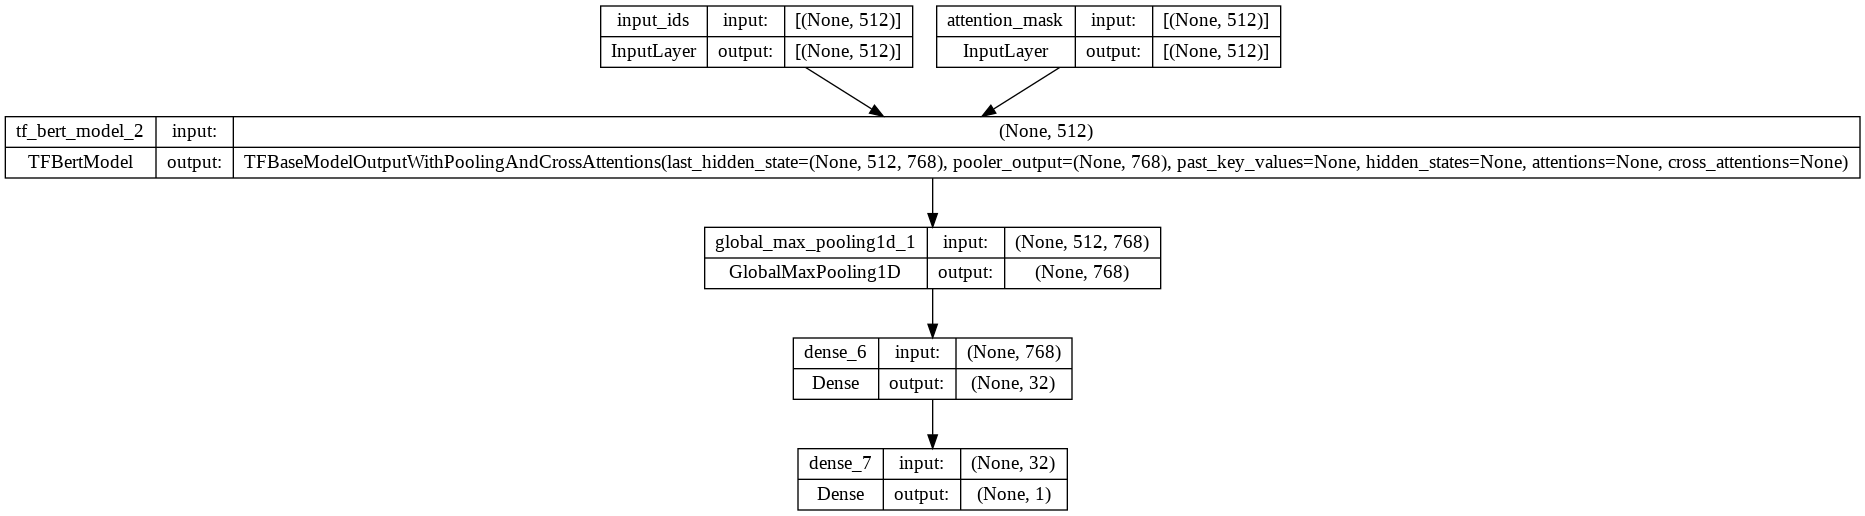

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(bert_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      
]

bert_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model_checkpoint_callback = ModelCheckpoint("./BERT.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

early = EarlyStopping(monitor='acc',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True
                          )

learning_rate_reduction = ReduceLROnPlateau(monitor='acc',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early, learning_rate_reduction,model_checkpoint_callback ]

In [ ]:
train_history = bert_model.fit(
    x ={'input_ids':train_data['input_ids'],'attention_mask':train_data['attention_mask']} ,
    y = train.sentiment,
    validation_data = (
    {'input_ids':test_data['input_ids'],'attention_mask':test_data['attention_mask']}, test.sentiment
    ),
    epochs=10,
    batch_size=36,
    callbacks=callbacks_list

)

Epoch 1/10
98/98 [==============================] - ETA: 0s - loss: 0.6834 - accuracy: 0.6246 - precision: 0.6692 - recall: 0.8609
Epoch 1: val_accuracy improved from -inf to 0.67038, saving model to ./BERT.h5
98/98 [==============================] - 316s 3s/step - loss: 0.6834 - accuracy: 0.6246 - precision: 0.6692 - recall: 0.8609 - val_loss: 0.6180 - val_accuracy: 0.6704 - val_precision: 0.6701 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/10
98/98 [==============================] - ETA: 0s - loss: 0.6228 - accuracy: 0.6637 - precision: 0.6800 - recall: 0.9334
Epoch 2: val_accuracy improved from 0.67038 to 0.69349, saving model to ./BERT.h5
98/98 [==============================] - 246s 3s/step - loss: 0.6228 - accuracy: 0.6637 - precision: 0.6800 - recall: 0.9334 - val_loss: 0.5905 - val_accuracy: 0.6935 - val_precision: 0.7120 - val_recall: 0.9105 - lr: 0.0010
Epoch 3/10
98/98 [==============================] - ETA: 0s - loss: 0.6034 - accuracy: 0.6663 - precision: 0.6954 - recall: 0.8

In [ ]:
# function for plotting the model history
def perf_plot(history):
  train_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']  

  fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

  ax[0].set_title('Accuracy vs. Epochs')
  ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
  ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend(loc='best')

  ax[1].set_title('Loss vs. Epochs')
  ax[1].plot(train_loss, 'o-', label='Train Loss')
  ax[1].plot(val_loss, 'o-', label='Validation Loss')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')
  ax[1].legend(loc='best')


  plt.tight_layout()
  plt.show()

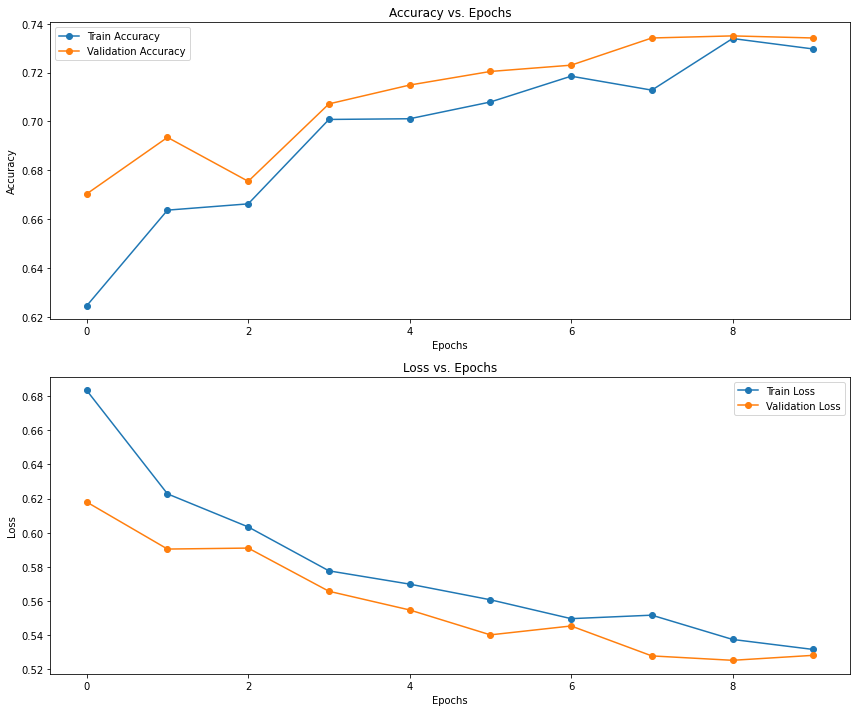

In [ ]:
perf_plot(train_history)

In [ ]:
prediction = bert_model.predict({'input_ids':test_data['input_ids'],'attention_mask':test_data['attention_mask']})

73/73 [==============================] - 90s 1s/step


In [ ]:
y_pred = [1 if pred>.5  else 0 for pred in prediction]

In [ ]:
# Generates a confusion matrix
def conf_matrix(y, y_pred, title,):
    fig, ax =plt.subplots(figsize=(7.5,7.5))
    ax=sn.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title, fontsize=25)
    # ax.xaxis.set_ticklabels(labels, fontsize=16) 
    # ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

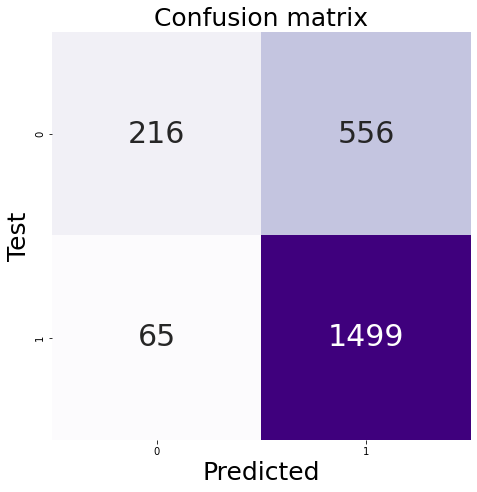

In [ ]:
conf_matrix(test.sentiment, y_pred, 'Confusion matrix')

In [ ]:
# Predicting Sentiment Original whole dataset
data = bert_tokenizer(
    text= dataset.tweet.tolist(),
    add_special_tokens=True,
    max_length=512,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [ ]:
data

{'input_ids': <tf.Tensor: shape=(4709, 512), dtype=int32, numpy=
array([[  101,   137,  1262, ...,     0,     0,     0],
       [  101,   137,  8468, ...,     0,     0,     0],
       [  101,   137,   152, ...,     0,     0,     0],
       ...,
       [  101,  1332,  3036, ...,     0,     0,     0],
       [  101,   137, 24181, ...,     0,     0,     0],
       [  101,  3570,   178, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(4709, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [ ]:
prediction = bert_model.predict({'input_ids':data['input_ids'],'attention_mask':data['attention_mask']})

148/148 [==============================] - 186s 1s/step


In [ ]:
y_pred = [1 if pred>.5  else 0 for pred in prediction]

In [ ]:
#adding this with the dataset columns
dataset['bert_sentiment'] = y_pred
dataset.head()

,Datetime,tweet,nr_tweet,c_tweet,hashtags,ats,m_tweet,h_tweet,a_tweet,no_of_punctuations,...,no_of_words_no_at_hash,length_of_tweet,is_there_digit,polarity,subjectivity,sentiment_score,sentiment,sentiment_nb,sentiment_Cat,bert_sentiment
0,2022-12-10 01:58:31+00:00,@AndToddsaid @pinkheretic Except the Apple com...,@AndToddsaid @pinkheretic Except the Apple com...,@andtoddsaid @pinkheretic except apple company...,[],"[@AndToddsaid, @pinkheretic]",except apple company part set fruit apples whe...,except apple company part set fruit apples whe...,@andtoddsaid @pinkheretic except apple company...,6,...,22,141,0,0.0,0.000,0.0,Positive,Neutral,1,1
1,2022-12-09 21:06:25+00:00,"@elonmusk apple company, I still I have been ...","@elonmusk apple company, I still I have been ...",@elonmusk apple company still going tenth seri...,[],[@elonmusk],apple company still going tenth series waiting...,apple company still going tenth series waiting...,@elonmusk apple company still going tenth seri...,7,...,54,288,0,-0.2,0.625,-0.2,Negative,Negative,0,1
3,2022-12-09 17:54:37+00:00,@OlaElectric Ola move 3.0 phir 4.0 phir 5.0 ly...,@OlaElectric Ola move 3.0 phir 4.0 phir 5.0 ly...,@olaelectric ola move 30 phir 40 phir 50 lya 2...,[],[@OlaElectric],ola move 30 phir 40 phir 50 lya 2032 tak mil j...,ola move 30 phir 40 phir 50 lya 2032 tak mil j...,@olaelectric ola move 30 phir 40 phir 50 lya 2...,11,...,49,256,10,0.0,0.000,0.0,Positive,Neutral,1,1
4,2022-12-09 15:58:11+00:00,"@NaughtieHazel In this life, you cum and you g...","@NaughtieHazel In this life, you cum and you g...",@naughtiehazel life cum go iphone 14 apple com...,[],[@NaughtieHazel],life cum go iphone 14 apple company release ip...,life cum go iphone 14 apple company release ip...,@naughtiehazel life cum go iphone 14 apple com...,5,...,25,144,4,0.0,0.000,0.0,Positive,Neutral,1,1
5,2022-12-09 13:31:28+00:00,@NBCNews apple company nor any of theme that w...,@NBCNews apple company nor any of theme that w...,@nbcnews apple company theme worked apple stve...,[],[@NBCNews],apple company theme worked apple stve job auth...,apple company theme worked apple stve job auth...,@nbcnews apple company theme worked apple stve...,2,...,24,149,4,0.5,0.750,0.5,Positive,Positive,1,1


In [ ]:
# So here y_pred is the sentiment predicted by the bert model.
# Hence add this as a new columns with clean_df dataframe
df_clean['bert_sentiment'] = y_pred
df_clean.head()

,Datetime,tweet,nr_tweet,c_tweet,hashtags,ats,m_tweet,h_tweet,a_tweet,no_of_punctuations,...,no_of_words_no_hash,no_of_words_no_at_hash,length_of_tweet,is_there_digit,polarity,subjectivity,sentiment_score,sentiment,sentiment_nb,bert_sentiment
0,2022-12-10 01:58:31+00:00,@AndToddsaid @pinkheretic Except the Apple com...,@AndToddsaid @pinkheretic Except the Apple com...,@andtoddsaid @pinkheretic except apple company...,[],"[@AndToddsaid, @pinkheretic]",except apple company part set fruit apples whe...,except apple company part set fruit apples whe...,@andtoddsaid @pinkheretic except apple company...,6,...,24,22,141,0,0.0,0.000,0.0,Positive,Neutral,1
1,2022-12-09 21:06:25+00:00,"@elonmusk apple company, I still I have been ...","@elonmusk apple company, I still I have been ...",@elonmusk apple company still going tenth seri...,[],[@elonmusk],apple company still going tenth series waiting...,apple company still going tenth series waiting...,@elonmusk apple company still going tenth seri...,7,...,55,54,288,0,-0.2,0.625,-0.2,Negative,Negative,1
3,2022-12-09 17:54:37+00:00,@OlaElectric Ola move 3.0 phir 4.0 phir 5.0 ly...,@OlaElectric Ola move 3.0 phir 4.0 phir 5.0 ly...,@olaelectric ola move 30 phir 40 phir 50 lya 2...,[],[@OlaElectric],ola move 30 phir 40 phir 50 lya 2032 tak mil j...,ola move 30 phir 40 phir 50 lya 2032 tak mil j...,@olaelectric ola move 30 phir 40 phir 50 lya 2...,11,...,50,49,256,10,0.0,0.000,0.0,Positive,Neutral,1
4,2022-12-09 15:58:11+00:00,"@NaughtieHazel In this life, you cum and you g...","@NaughtieHazel In this life, you cum and you g...",@naughtiehazel life cum go iphone 14 apple com...,[],[@NaughtieHazel],life cum go iphone 14 apple company release ip...,life cum go iphone 14 apple company release ip...,@naughtiehazel life cum go iphone 14 apple com...,5,...,26,25,144,4,0.0,0.000,0.0,Positive,Neutral,1
5,2022-12-09 13:31:28+00:00,@NBCNews apple company nor any of theme that w...,@NBCNews apple company nor any of theme that w...,@nbcnews apple company theme worked apple stve...,[],[@NBCNews],apple company theme worked apple stve job auth...,apple company theme worked apple stve job auth...,@nbcnews apple company theme worked apple stve...,2,...,25,24,149,4,0.5,0.750,0.5,Positive,Positive,1


In [ ]:
#converting the datetime columns into date format to merge it with the stock price dataframe

df_clean['Date'] = pd.to_datetime(df['Datetime']).dt.date

In [ ]:
df_clean.head()

,Datetime,tweet,nr_tweet,c_tweet,hashtags,ats,m_tweet,h_tweet,a_tweet,no_of_punctuations,...,no_of_words_no_at_hash,length_of_tweet,is_there_digit,polarity,subjectivity,sentiment_score,sentiment,sentiment_nb,bert_sentiment,Date
0,2022-12-10 01:58:31+00:00,@AndToddsaid @pinkheretic Except the Apple com...,@AndToddsaid @pinkheretic Except the Apple com...,@andtoddsaid @pinkheretic except apple company...,[],"[@AndToddsaid, @pinkheretic]",except apple company part set fruit apples whe...,except apple company part set fruit apples whe...,@andtoddsaid @pinkheretic except apple company...,6,...,22,141,0,0.0,0.000,0.0,Positive,Neutral,1,2022-12-10
1,2022-12-09 21:06:25+00:00,"@elonmusk apple company, I still I have been ...","@elonmusk apple company, I still I have been ...",@elonmusk apple company still going tenth seri...,[],[@elonmusk],apple company still going tenth series waiting...,apple company still going tenth series waiting...,@elonmusk apple company still going tenth seri...,7,...,54,288,0,-0.2,0.625,-0.2,Negative,Negative,1,2022-12-09
3,2022-12-09 17:54:37+00:00,@OlaElectric Ola move 3.0 phir 4.0 phir 5.0 ly...,@OlaElectric Ola move 3.0 phir 4.0 phir 5.0 ly...,@olaelectric ola move 30 phir 40 phir 50 lya 2...,[],[@OlaElectric],ola move 30 phir 40 phir 50 lya 2032 tak mil j...,ola move 30 phir 40 phir 50 lya 2032 tak mil j...,@olaelectric ola move 30 phir 40 phir 50 lya 2...,11,...,49,256,10,0.0,0.000,0.0,Positive,Neutral,1,2022-12-09
4,2022-12-09 15:58:11+00:00,"@NaughtieHazel In this life, you cum and you g...","@NaughtieHazel In this life, you cum and you g...",@naughtiehazel life cum go iphone 14 apple com...,[],[@NaughtieHazel],life cum go iphone 14 apple company release ip...,life cum go iphone 14 apple company release ip...,@naughtiehazel life cum go iphone 14 apple com...,5,...,25,144,4,0.0,0.000,0.0,Positive,Neutral,1,2022-12-09
5,2022-12-09 13:31:28+00:00,@NBCNews apple company nor any of theme that w...,@NBCNews apple company nor any of theme that w...,@nbcnews apple company theme worked apple stve...,[],[@NBCNews],apple company theme worked apple stve job auth...,apple company theme worked apple stve job auth...,@nbcnews apple company theme worked apple stve...,2,...,24,149,4,0.5,0.750,0.5,Positive,Positive,1,2022-12-09


In [ ]:
df_clean.to_csv('bert_sentiment.csv', index = False)

# Stock Prediction

In [ ]:
# Load stock data
stock_df = pd.read_csv('AAPL.csv')
stock_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-08-31,28.007500,28.632500,28.000000,28.190001,25.740059,224917200
1,2015-09-01,27.537500,27.969999,26.840000,26.930000,24.589560,307383600
2,2015-09-02,27.557501,28.084999,27.282499,28.084999,25.644180,247555200
3,2015-09-03,28.122499,28.195000,27.510000,27.592501,25.194494,212935600
4,2015-09-04,27.242500,27.612499,27.127501,27.317499,24.943388,199985200


In [ ]:
stock_df[stock_df.columns[1:]] = stock_df[stock_df.columns[1:]].replace('[\$,]', '', regex=True).astype(float)

In [ ]:
stock_df['Date'] = pd.to_datetime(stock_df['Date'], utc = True)
df_clean['Date'] = pd.to_datetime(df_clean['Date'], utc = True)

In [ ]:
# Join the dataframes
stock_df.reset_index(drop=True, inplace=True)
df_clean.reset_index(drop=True, inplace=True)
# stock_sentiment_df = pd.concat([df_clean,stock_df], axis = 1, sort=False)
# stock_sentiment_df.head()

In [ ]:
stock_sentiment_df = pd.merge(stock_df, df_clean, on="Date")
stock_sentiment_df.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Datetime,tweet,nr_tweet,...,no_of_words_no_hash,no_of_words_no_at_hash,length_of_tweet,is_there_digit,polarity,subjectivity,sentiment_score,sentiment,sentiment_nb,bert_sentiment
0,2021-05-27 00:00:00+00:00,126.440002,127.639999,125.080002,125.279999,124.395523,94625600.0,2021-05-27 16:37:28+00:00,"FOLLOW Hannah Apple COMPANY, THEY ARE SAVING T...","FOLLOW Hannah Apple COMPANY, THEY ARE SAVING T...",...,32,31,277,11,1.0,0.3,1.0,Positive,Positive,1
1,2021-05-27 00:00:00+00:00,126.440002,127.639999,125.080002,125.279999,124.395523,94625600.0,2021-05-27 16:27:33+00:00,CORE BLIMEY: Luxury #Macclesfield apple compan...,CORE BLIMEY: Luxury #Macclesfield apple compan...,...,15,15,126,3,-0.2,0.0,-0.2,Negative,Negative,1
2,2021-05-27 00:00:00+00:00,126.440002,127.639999,125.080002,125.279999,124.395523,94625600.0,2021-05-27 16:05:02+00:00,@AppleSupport Please send me iPhone 12 pro ult...,@AppleSupport Please send me iPhone 12 pro ult...,...,19,18,118,2,0.2,0.2,0.2,Positive,Positive,1
3,2021-05-27 00:00:00+00:00,126.440002,127.639999,125.080002,125.279999,124.395523,94625600.0,2021-05-27 14:03:34+00:00,@ZacksJerryRig @tim_cook Standard we believe t...,@ZacksJerryRig @tim_cook Standard we believe t...,...,8,6,69,0,0.0,0.0,0.0,Positive,Neutral,1
4,2021-05-27 00:00:00+00:00,126.440002,127.639999,125.080002,125.279999,124.395523,94625600.0,2021-05-27 14:01:12+00:00,@hjscools bilhin mo yung apple company,@hjscools bilhin mo yung apple company,...,5,4,38,0,0.0,0.0,0.0,Positive,Neutral,1


In [ ]:
stock_sentiment_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Datetime', 'tweet', 'nr_tweet', 'c_tweet', 'hashtags', 'ats',
       'm_tweet', 'h_tweet', 'a_tweet', 'no_of_punctuations', 'no_of_at',
       'no_of_hashes', 'no_of_words', 'no_of_words_no_at',
       'no_of_words_no_hash', 'no_of_words_no_at_hash', 'length_of_tweet',
       'is_there_digit', 'polarity', 'subjectivity', 'sentiment_score',
       'sentiment', 'sentiment_nb', 'bert_sentiment'],
      dtype='object')

In [ ]:
stock_sentiment_df.to_csv('Combine.csv', index = False)

In [ ]:
stock_sentiment_df = pd.read_csv('Combine.csv')

In [ ]:
stock_sentiment_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Datetime,tweet,nr_tweet,...,no_of_words_no_hash,no_of_words_no_at_hash,length_of_tweet,is_there_digit,polarity,subjectivity,sentiment_score,sentiment,sentiment_nb,bert_sentiment
0,2021-05-27 00:00:00+00:00,126.440002,127.639999,125.080002,125.279999,124.395523,94625600.0,2021-05-27 16:37:28+00:00,"FOLLOW Hannah Apple COMPANY, THEY ARE SAVING T...","FOLLOW Hannah Apple COMPANY, THEY ARE SAVING T...",...,32,31,277,11,1.0,0.3,1.0,Positive,Positive,1
1,2021-05-27 00:00:00+00:00,126.440002,127.639999,125.080002,125.279999,124.395523,94625600.0,2021-05-27 16:27:33+00:00,CORE BLIMEY: Luxury #Macclesfield apple compan...,CORE BLIMEY: Luxury #Macclesfield apple compan...,...,15,15,126,3,-0.2,0.0,-0.2,Negative,Negative,1
2,2021-05-27 00:00:00+00:00,126.440002,127.639999,125.080002,125.279999,124.395523,94625600.0,2021-05-27 16:05:02+00:00,@AppleSupport Please send me iPhone 12 pro ult...,@AppleSupport Please send me iPhone 12 pro ult...,...,19,18,118,2,0.2,0.2,0.2,Positive,Positive,1
3,2021-05-27 00:00:00+00:00,126.440002,127.639999,125.080002,125.279999,124.395523,94625600.0,2021-05-27 14:03:34+00:00,@ZacksJerryRig @tim_cook Standard we believe t...,@ZacksJerryRig @tim_cook Standard we believe t...,...,8,6,69,0,0.0,0.0,0.0,Positive,Neutral,1
4,2021-05-27 00:00:00+00:00,126.440002,127.639999,125.080002,125.279999,124.395523,94625600.0,2021-05-27 14:01:12+00:00,@hjscools bilhin mo yung apple company,@hjscools bilhin mo yung apple company,...,5,4,38,0,0.0,0.0,0.0,Positive,Neutral,1


In [ ]:
stock_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [ ]:
stock_sentiment_df1 = stock_sentiment_df[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'polarity', 'bert_sentiment']]
stock_sentiment_df1.head()

,Date,Open,High,Low,Close,Adj Close,Volume,polarity,bert_sentiment
0,2021-05-27 00:00:00+00:00,126.440002,127.639999,125.080002,125.279999,124.395523,94625600.0,1.0,1
1,2021-05-27 00:00:00+00:00,126.440002,127.639999,125.080002,125.279999,124.395523,94625600.0,-0.2,1
2,2021-05-27 00:00:00+00:00,126.440002,127.639999,125.080002,125.279999,124.395523,94625600.0,0.2,1
3,2021-05-27 00:00:00+00:00,126.440002,127.639999,125.080002,125.279999,124.395523,94625600.0,0.0,1
4,2021-05-27 00:00:00+00:00,126.440002,127.639999,125.080002,125.279999,124.395523,94625600.0,0.0,1


In [ ]:
stock_sentiment_df1.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'polarity', 'bert_sentiment'],
      dtype='object')

# LSTM Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, LSTM, GRU
from keras.layers import Dropout
from keras.layers import *
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D
from tensorflow.compat.v1.keras.layers import CuDNNLSTM,Bidirectional
seed=42

## Stock With Sentiments

As we are trying to see the effects of sentiment so along side one of open, high, low etc. we will add the sentimetn columns,

In [ ]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [ ]:
#Cnverting the datetime coluns into date dype
stock_sentiment_df1['Date'] = pd.to_datetime(stock_sentiment_df1['Date']).dt.date

In [ ]:
stock_sentiment_df1.head()

,Date,Open,High,Low,Close,Adj Close,Volume,polarity,bert_sentiment
0,2021-05-27,126.440002,127.639999,125.080002,125.279999,124.395523,94625600.0,1.0,1
1,2021-05-27,126.440002,127.639999,125.080002,125.279999,124.395523,94625600.0,-0.2,1
2,2021-05-27,126.440002,127.639999,125.080002,125.279999,124.395523,94625600.0,0.2,1
3,2021-05-27,126.440002,127.639999,125.080002,125.279999,124.395523,94625600.0,0.0,1
4,2021-05-27,126.440002,127.639999,125.080002,125.279999,124.395523,94625600.0,0.0,1


In [ ]:

# Taking oly the adjclose for comparing it with the predicted value.
adjclose = stock_sentiment_df1.reset_index()['Adj Close']
adjclose

0       124.395523
1       124.395523
2       124.395523
3       124.395523
4       124.395523
           ...    
2338    158.910004
2339    158.910004
2340    158.910004
2341    158.910004
2342    158.910004
Name: Adj Close, Length: 2343, dtype: float64

In [ ]:
# Taking both the adj close and the sentiment together to train the model.

adj_close=np.array(stock_sentiment_df1.reset_index()['Adj Close']).reshape(-1,1)
sentiment = np.array(stock_sentiment_df1.reset_index()['bert_sentiment']).reshape(-1,1)

In [ ]:
#scaling down the adj_column
from sklearn.preprocessing import StandardScaler,MinMaxScaler
ms=MinMaxScaler(feature_range=(0,1))
adj_close=ms.fit_transform(adj_close)

In [ ]:
print(adj_close, sentiment)

[[0.02948703]
 [0.02948703]
 [0.02948703]
 ...
 [0.61855074]
 [0.61855074]
 [0.61855074]] [[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]


In [ ]:
#Spliting the dataset into train and test part
train_size=int(len(adj_close)*0.70)
test_size=len(adj_close)-train_size
train_adjclose, train_sentiment = adj_close[0:train_size,:], sentiment[0:train_size,:]
test_adjclose, test_sentiment = adj_close[train_size:len(adj_close),:1], sentiment[train_size:len(adj_close),:1]


In [ ]:
# Finding the length of data points in train and test part
len(train_adjclose), len(test_adjclose)

(1640, 703)

In [ ]:
#Views of the train adjclose data
train_adjclose

array([[0.02948703],
       [0.02948703],
       [0.02948703],
       ...,
       [0.7193929 ],
       [0.7193929 ],
       [0.7193929 ]])

In [ ]:
#Function definition of creating the dataset
def creating_dataset(data, sent, time_step=1):
  X, Y = [], [] # variable for storing the dependent and independent features.
  for i in range(len(data)-time_step-1):
    global value, positive_sent_count
    value =  data[i:(i+time_step), 0],   # storing the value for the defined timesstep
    positive_sent_count =  list(sent[i:(i+time_step), 0]).count(1)  # counting the numbers pos sent in specific time steps
    combine = np.append(value,positive_sent_count) # Appending the price value  and the sentiment together.
    X.append(combine)
    Y.append(data[i + time_step, 0]) 
  return np.array(X), np.array(Y)



In [ ]:
# calling the creating-dataset to generate the train and test data.
time_step = 50
X_train, y_train = creating_dataset(train_adjclose, train_sentiment, time_step)
X_test, y_test = creating_dataset(test_adjclose, test_sentiment, time_step)

In [ ]:
#views if x_train data
X_train

array([[2.94870288e-02, 2.94870288e-02, 2.94870288e-02, ...,
        5.42291348e-02, 5.42291348e-02, 5.00000000e+01],
       [2.94870288e-02, 2.94870288e-02, 2.94870288e-02, ...,
        5.42291348e-02, 5.42291348e-02, 5.00000000e+01],
       [2.94870288e-02, 2.94870288e-02, 2.94870288e-02, ...,
        5.42291348e-02, 5.42291348e-02, 5.00000000e+01],
       ...,
       [8.35969343e-01, 8.01081381e-01, 8.01081381e-01, ...,
        7.19392897e-01, 7.19392897e-01, 5.00000000e+01],
       [8.01081381e-01, 8.01081381e-01, 8.01081381e-01, ...,
        7.19392897e-01, 7.19392897e-01, 5.00000000e+01],
       [8.01081381e-01, 8.01081381e-01, 8.01081381e-01, ...,
        7.19392897e-01, 7.19392897e-01, 5.00000000e+01]])

In [ ]:
#here the 2nd shape is 51 beacause the 51th value is number of pos sentiment that particular time frame

X_train.shape, y_train.shape

((1589, 51), (1589,))

In [ ]:
# reshaping the data according to the LSTM model.
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
#shape of X-train after reshaping according to the lstm model
X_train.shape

(1589, 51, 1)

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape= (51,1)))
model.add(LSTM(256, return_sequences=True, ))
model.add(LSTM(128, return_sequences=True,))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
history = model.fit(X_train,y_train,
                    validation_data=(X_test,y_test),
                    epochs=50,
                    batch_size=64,
                    verbose=1)

Epoch 1/50
25/25 [==============================] - 9s 84ms/step - loss: 0.0693 - val_loss: 0.0126
Epoch 2/50
25/25 [==============================] - 1s 28ms/step - loss: 0.0061 - val_loss: 0.0048
Epoch 3/50
25/25 [==============================] - 1s 29ms/step - loss: 0.0027 - val_loss: 0.0038
Epoch 4/50
25/25 [==============================] - 1s 28ms/step - loss: 0.0022 - val_loss: 0.0036
Epoch 5/50
25/25 [==============================] - 1s 28ms/step - loss: 0.0021 - val_loss: 0.0034
Epoch 6/50
25/25 [==============================] - 1s 28ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 7/50
25/25 [==============================] - 1s 28ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 8/50
25/25 [==============================] - 1s 28ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 9/50
25/25 [==============================] - 1s 28ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 10/50
25/25 [==============================] - 1s 28ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 11/

In [ ]:
#Model Evaluation
pred_train=model.predict(X_train)
pred_test=model.predict(X_test)

21/21 [==============================] - 0s 8ms/step


In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
error_with_sentiment = math.sqrt(mean_squared_error(pred_test,y_test))
error_with_sentiment

0.034700774088822293

In [ ]:
#For comparing our model performane have transform the predicted value as like as original data.
##Transformback to original form
pred_train=ms.inverse_transform(pred_train)
pred_test=ms.inverse_transform(pred_test)

In [ ]:
total_predict_with_sentiment = np.append(pred_train, pred_test)
len(total_predict_with_sentiment)

2241

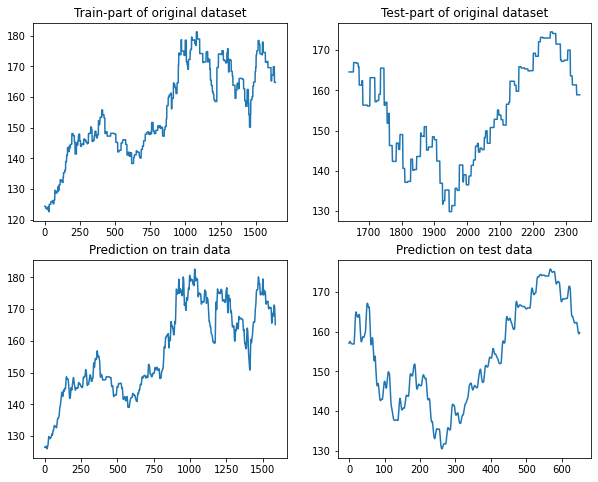

In [ ]:
# Initialise the subplot function using number of rows and columns

figure, axis = plt.subplots(2, 2, figsize=(10, 8))
  
# For Sine Function
axis[0, 0].plot(adjclose[:1640])
axis[0, 0].set_title("Train-part of original dataset")
  
# For Cosine Function
axis[0, 1].plot(adjclose[1640:len(adjclose)])
axis[0, 1].set_title("Test-part of original dataset")
  
# For Tangent Function
axis[1, 0].plot(pred_train)
axis[1, 0].set_title("Prediction on train data")
  
# For Tanh Function
axis[1, 1].plot(pred_test)
axis[1, 1].set_title("Prediction on test data")
  
# Combine all the operations and display
plt.show()

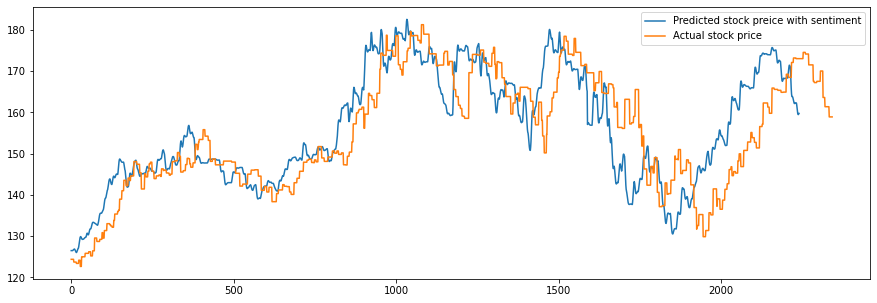

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(total_predict_with_sentiment, label = "Predicted stock preice with sentiment")
plt.plot(adjclose, label = "Actual stock price")
plt.legend()
plt.show()

# **LSTM model with out adding the sentiment.**

In [ ]:
def creating_dataset(data, time_step=1):
  X, Y = [], []
  for i in range(len(data)-time_step-1):
    global value
    value =  data[i:(i+time_step), 0]
    X.append(value)
    Y.append(data[i + time_step, 0]) 
  return np.array(X), np.array(Y)

In [ ]:
time_step = 50
X_train, y_train = creating_dataset(train_adjclose, time_step)
X_test, y_test = creating_dataset(test_adjclose, time_step)
# reshaping the data according to the LSTM model.
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
X_train.shape

(1589, 50, 1)

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape= (50,1)))
model.add(LSTM(256, return_sequences=True, ))
model.add(LSTM(128, return_sequences=True,))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
history = model.fit(X_train,y_train,
                    validation_data=(X_test,y_test),
                    epochs=30,
                    batch_size=64,
                    verbose=1)

Epoch 1/30
25/25 [==============================] - 9s 85ms/step - loss: 0.0478 - val_loss: 0.0085
Epoch 2/30
25/25 [==============================] - 1s 28ms/step - loss: 0.0038 - val_loss: 0.0042
Epoch 3/30
25/25 [==============================] - 1s 28ms/step - loss: 0.0025 - val_loss: 0.0044
Epoch 4/30
25/25 [==============================] - 1s 28ms/step - loss: 0.0022 - val_loss: 0.0035
Epoch 5/30
25/25 [==============================] - 1s 28ms/step - loss: 0.0020 - val_loss: 0.0034
Epoch 6/30
25/25 [==============================] - 1s 28ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 7/30
25/25 [==============================] - 1s 28ms/step - loss: 0.0018 - val_loss: 0.0036
Epoch 8/30
25/25 [==============================] - 1s 28ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 9/30
25/25 [==============================] - 1s 28ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 10/30
25/25 [==============================] - 1s 27ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 11/

In [ ]:
#Model Evaluation
pred_train=model.predict(X_train)
pred_test=model.predict(X_test)
#For comparing our model performane have transform the predicted value as like as original data.
##Transformback to original form
pred_train=ms.inverse_transform(pred_train)
pred_test=ms.inverse_transform(pred_test)

21/21 [==============================] - 0s 7ms/step


In [ ]:
error_without_sentiment = math.sqrt(mean_squared_error(pred_test,y_test))
error_without_sentiment

153.1880582854322

In [ ]:
total_predict_without_sentiment = np.append(pred_train, pred_test)
len(total_predict_without_sentiment)

2241

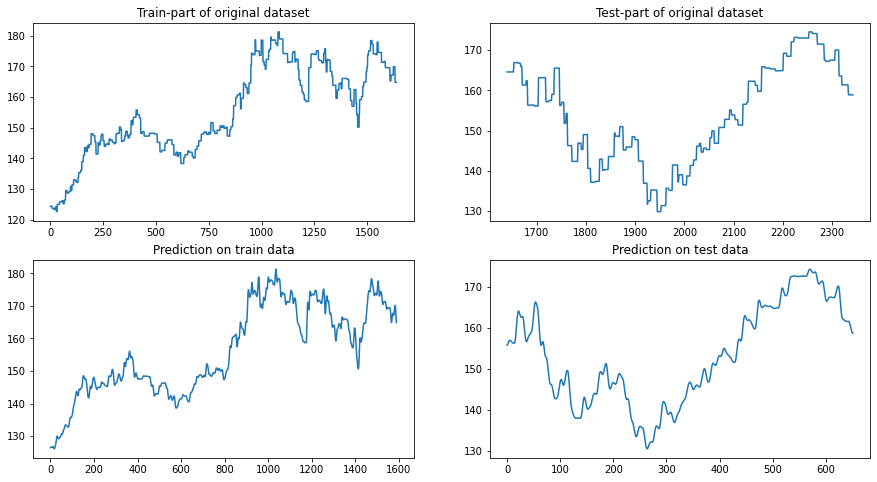

In [ ]:
# Initialise the subplot function using number of rows and columns

figure, axis = plt.subplots(2, 2, figsize=(15, 8))
  
# For Sine Function
axis[0, 0].plot(adjclose[:1640])
axis[0, 0].set_title("Train-part of original dataset")
  
# For Cosine Function
axis[0, 1].plot(adjclose[1640:len(adjclose)])
axis[0, 1].set_title("Test-part of original dataset")
  
# For Tangent Function
axis[1, 0].plot(pred_train)
axis[1, 0].set_title("Prediction on train data")
  
# For Tanh Function
axis[1, 1].plot(pred_test)
axis[1, 1].set_title("Prediction on test data")
  
# Combine all the operations and display
plt.show()

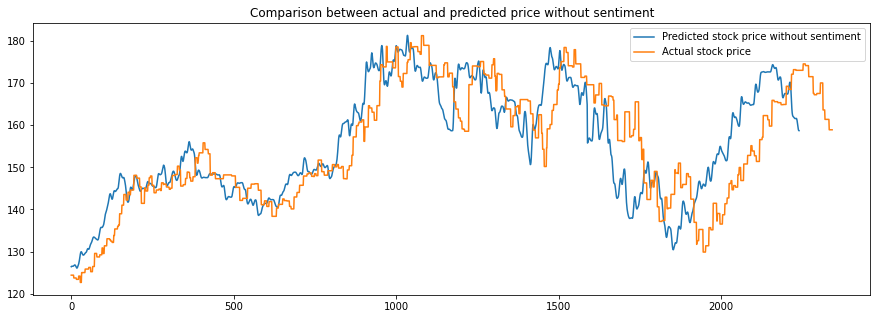

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(total_predict_without_sentiment, label = "Predicted stock price without sentiment")
plt.plot(adjclose, label = "Actual stock price")
plt.title('Comparison between actual and predicted price without sentiment')
plt.legend()
plt.show()

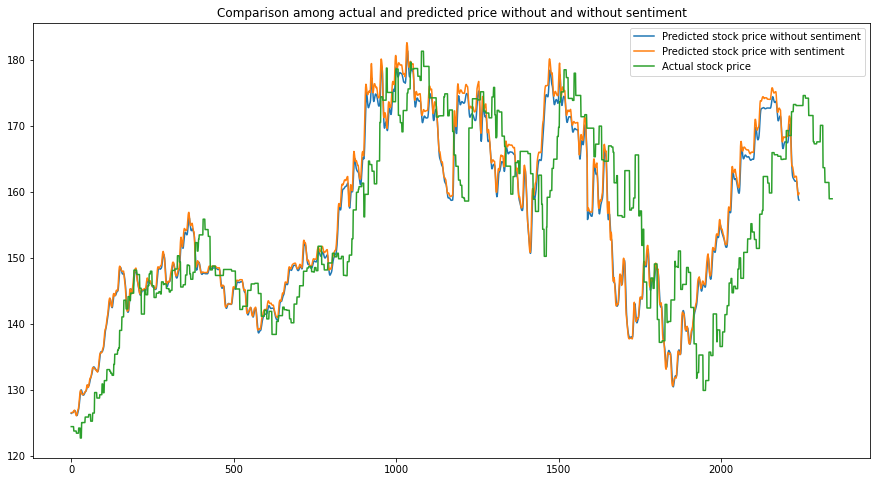

In [ ]:
#Comparing the among with and without the sentiment with the actual price.
plt.figure(figsize=(15,8))
plt.plot(total_predict_without_sentiment, label = "Predicted stock price without sentiment")
plt.plot(total_predict_with_sentiment, label = "Predicted stock price with sentiment")
plt.plot(adjclose, label = "Actual stock price")
plt.title('Comparison among actual and predicted price without and without sentiment')
plt.legend()
plt.show()